# Mod 4 Project - Time Series Predictions


## Import Libraries and initial settings

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools

# import folium
# from ast import literal_eval
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from pmdarima.arima import auto_arima


In [4]:
#Define Pandas display options for inspection 
# Set max rows to display to 2000
pd.set_option('display.max_rows', 2000)
# Set max columns to display to 500
pd.set_option('display.max_columns', 500)

## User defined functions

In [5]:
#This function is used to address stationarity per zipcode

def stationarityTest(ts, wd = 4):
    
    #ts is the time series with time as index and target variable
    #wd is the window for the rolling statistics test
    #zipcode is the zipcode under analysis
    
    rolmean = ts.rolling(window = wd, center = False).mean()
    rolstd = ts.rolling(window = wd, center = False).std()
    fig = plt.figure(figsize = (8, 4))
    orig = plt.plot(ts, color ='blue', label = 'Original')
    mean = plt.plot(rolmean, color ='red', label ='Rolling Mean')
    std = plt.plot(rolstd, color ='black', label ='Rolling Std')
    plt.legend(loc ='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Dikie Fuller test only accepts 1d series, therefore we pass the values column only
    dftest = adfuller(ts['value'])
    dfoutput = pd.Series(dftest[0:4], index =['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key] = value
    return(dfoutput)

In [6]:
def train_test_split(data):
    
    n = len(data['value'])
    training_n = int(n*0.8)
    
    for i in range(0, len(data)):
    #Split datasets into training and testing
        train_df = data.iloc[:training_n]
        test_df = data.iloc[training_n:]
    
    return train_df, test_df

In [7]:
def tsrollingmean(ts,wd = 2):
    rolmean = ts.rolling(window = wd).mean()
    data_minus_rolmean = ts - rolmean
    data_minus_rolmean.dropna(inplace=True)
    return(data_minus_rolmean)

In [8]:
# Plot the autocorrelation and partial autocorrelation functions for a given dataset and number of lags
def check_autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

In [ ]:
# Identify optimal order of SARIMAX function.  p, d, and q represent maximum values
def optimise_sarimax(df, p, d, q):
    
    # Create a list with all possible values for p, d and q up to specified maximum
    p = list(range(0,p))
    d = list(range(0,d))
    q = list(range(0,q))


    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency given annual cyclicality)
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    
    # Create dataframe that displays order v. AIC criterion.  Order with lowest AIC selected
    results = []

    for i in range(0, len(pdqs)):
        model = sm.tsa.statespace.SARIMAX(endog=df, order = pdq[i], seasonal_order = pdqs[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS')
        result = model.fit(maxiter=200)
        results.append({'pdq': f"{pdq[i]}", 'pdqs': f"{pdqs[i]}", 'AIC':result.aic})
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=['AIC'], ascending = True, inplace=True)
    
    return results_df

In [ ]:
# Charts a model's predictions against actual values
def make_predictions(model, date, df, position):
    
    fig.add_subplot(position)
    
    pred = model.get_prediction(start=pd.to_datetime(date), dynamic=False)
    pred_conf = pred.conf_int()
    
    
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    df['2007':].plot(label='observed', ax=ax)

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('House Price')
  

    plt.show()

# EDA

In [19]:
#Load updated data
df = pd.read_csv('UpdatedZillow.csv', encoding='latin-1')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,168300.0,168400.0,168400.0,168400.0,168400.0,168600.0,169200.0,170000.0,171500.0,173300.0,175100.0,176900.0,178600.0,180100.0,181500.0,182700.0,183800.0,184900.0,186300.0,188000.0,190100.0,192700.0,195500.0,198400.0,201500.0,204700.0,208100.0,211500.0,215100.0,218800.0,222700.0,226700.0,231100.0,235800.0,240600.0,245400.0,250600.0,255900.0,261300.0,267200.0,273600.0,280500.0,288100.0,296300.0,305100.0,314300.0,323500.0,332200.0,340600.0,348300.0,355100.0,361300.0,367200.0,372800.0,378400.0,384100.0,389900.0,395800.0,401600.0,406900.0,411500.0,415200.0,417800.0,419400.0,420400.0,421000.0,421300.0,421200.0,420500.0,419700.0,418900.0,417900.0,416400.0,414800.0,413100.0,411700.0,411000.0,411500.0,412800.0,415400.0,419000.0,422800.0,426900.0,432400.0,440700.0,453100.0,470400.0,491100.0,511600.0,528400.0,540300.0,547700.0,551700.0,554200.0,556400.0,558700.0,561300.0,564100.0,567500.0,572500.0,579600.0,589000.0,599600.0,610200.0,621600.0,634500.0,648800.0,663800.0,678200.0,690900.0,701600.0,710300.0,717600.0,724100.0,730700.0,737400.0,744200.0,751400.0,758400.0,764700.0,769900.0,773600.0,774900.0,772600.0,767200.0,761800.0,760300.0,763700.0,770500.0,778000.0,785000.0,791100.0,795800.0,799300.0,803200.0,809500.0,819400.0,831500.0,843200.0,851900.0,856000.0,856900.0,856100.0,852800.0,845800.0,836100.0,825900.0,820200.0,820800.0,822900.0,822100.0,818500.0,812600.0,807300.0,804600.0,803100.0,801200.0,800200.0,795500.0,783100.0,766900.0,753100.0,743800.0,738500.0,739400.0,740800.0,738600.0,736900.0,744400.0,758600.0,775100.0,789000.0,792600.0,784900.0,777200.0,777000.0,775900.0,772000.0,767600.0,763

In [ ]:
# Load the dataset
df = pd.read_csv('zillow_data.csv')
df.head()

In [20]:
#Check the number of columns in dataframe
len(df.columns)

289

North West Arkansas (NWA) is home of the Walmart Headquarters. 
Washigton and Benton County are growing rapidly as the new Walmart campus was announced to be openened on 2025.

In [21]:
#Select State of AR only
dfAR = df.loc[df['State'] == 'AR']

In [24]:
dfAR.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
309,89249,71913,Hot Springs,AR,Hot Springs,Garland County,310,81600.0,81700.0,81700.0,81700.0,81600.0,81400.0,81300.0,81100.0,81000.0,80800.0,80700.0,80600.0,80800.0,81200.0,81800.0,82600.0,83400.0,84300.0,85100.0,85800.0,86500.0,87200.0,87800.0,88200.0,88600.0,89000.0,89200.0,89300.0,89300.0,89200.0,89100.0,88900.0,88800.0,88700.0,88600.0,88400.0,88300.0,88200.0,88100.0,88200.0,88400.0,88800.0,89200.0,89700.0,90400.0,91100.0,91800.0,92400.0,92800.0,93200.0,93500.0,93700.0,93900.0,94100.0,94300.0,94600.0,94900.0,95300.0,95700.0,96000.0,96200.0,96300.0,96300.0,96300.0,96300.0,96300.0,96400.0,96600.0,96900.0,97200.0,97500.0,97800.0,98000.0,98200.0,98300.0,98600.0,98900.0,99400.0,100000.0,100800.0,101800.0,102900.0,104100.0,105200.0,106400.0,107500.0,108600.0,109600.0,110700.0,111500.0,112200.0,112800.0,113300.0,113800.0,114300.0,114900.0,115700.0,116600.0,117500.0,118400.0,119300.0,120200.0,120900.0,121600.0,122100.0,122600.0,123200.0,124100.0,125200.0,126500.0,127900.0,129500.0,131000.0,132500.0,133800.0,134900.0,135800.0,136500.0,137200.0,137800.0,138300.0,138700.0,139200.0,139700.0,140300.0,141200.0,142000.0,142700.0,143300.0,143800.0,144000.0,143800.0,143400.0,143100.0,142900.0,142700.0,142500.0,142100.0,141600.0,141000.0,140500.0,140000.0,139900.0,139700.0,139600.0,139700.0,139900.0,140000.0,139700.0,139400.0,139000.0,138700.0,138300.0,138000.0,137900.0,137700.0,137200.0,136900.0,136700.0,136400.0,136300.0,136500.0,137000.0,137400.0,138200.0,138800.0,138700.0,138900.0,139800.0,139700.0,138900.0,138300.0,137500.0,136500.0,135600.0,135200.0,135100.0,135300.0,135600.0,136200.0,136500.0,136300.0,135600.0,134600.0,133500.0,133000.0,132600.0,131900.0,131400.0,1

In [25]:
#Select Washington and Benton Countys from AR
dfARCounty = dfAR.loc[dfAR['CountyName'].isin(['Washington County', 'Benton County'])]

In [26]:
dfARCounty.head(2)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
808,89707,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,Washington County,809,83100.0,83400.0,83500.0,83500.0,83400.0,83400.0,83300.0,83200.0,83100.0,83400.0,83900.0,84500.0,85000.0,85400.0,85500.0,85700.0,85700.0,85700.0,85700.0,85700.0,85700.0,85900.0,86400.0,86900.0,87200.0,87200.0,87200.0,87100.0,87000.0,87000.0,87100.0,87300.0,87600.0,88300.0,89300.0,90400.0,91200.0,91700.0,91900.0,91800.0,91500.0,91200.0,90800.0,90400.0,90100.0,90300.0,91100.0,92100.0,93300.0,94500.0,95700.0,97100.0,98600.0,100300.0,102100.0,103900.0,105500.0,107200.0,109200.0,111200.0,112400.0,112900.0,112500.0,111300.0,109500.0,107200.0,104900.0,102400.0,100100.0,98400.0,97900.0,98100.0,98700.0,99500.0,100600.0,102200.0,104300.0,106800.0,109300.0,112900.0,117900.0,120300.0,117400.0,112600.0,109300.0,107800.0,107900.0,109400.0,111500.0,113700.0,116100.0,118300.0,120100.0,121900.0,124200.0,126800.0,129300.0,131700.0,133800.0,135700.0,137500.0,139200.0,140700.0,141600.0,142000.0,142600.0,144100.0,145700.0,147200.0,148200.0,148900.0,149800.0,150900.0,152100.0,153400.0,154500.0,155300.0,156500.0,158600.0,161600.0,164800.0,167900.0,170300.0,172000.0,173100.0,173600.0,173800.0,173900.0,174200.0,175100.0,176100.0,177200.0,177700.0,177200.0,175900.0,174500.0,173000.0,171800.0,170700.0,169700.0,168900.0,168300.0,167500.0,167000.0,166700.0,166300.0,165700.0,165100.0,164400.0,163700.0,163100.0,162600.0,162100.0,161500.0,160800.0,160300.0,160000.0,159300.0,158600.0,158500.0,158600.0,158800.0,159000.0,159100.0,158400.0,158000.0,158500.0,157100.0,153600.0,152100.0,153200.0,153800.0,153600.0,153800.0,154200.0,153900.0,153300.0,152400.0,151500.0,151700.0,153300.0,153900.0,152800.0,151100.0,149

In [27]:
#Check the number of NAs per zipcode
cols = list(dfARCounty.columns[7:])
dfARCounty['NumberMissingValues'] = dfARCounty[cols].isna().sum(axis=1)
dfARCounty['NumberMissingValues'].value_counts()

0      19
219     1
87      1
Name: NumberMissingValues, dtype: int64

In [28]:
dfARCounty[dfARCounty['NumberMissingValues']>0]

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,NumberMissingValues
851,89749,72764,Springdale,AR,Fayetteville-Springdale-Rogers,Washington County,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104700.0,106500.0,108300.0,110100.0,111400.0,112000.0,112800.0,114500.0,116700.0,119000.0,121300.0,123500.0,125400.0,127000.0,128100.0,129000.0,129200.0,129000.0,129200.0,130300.0,131800.0,133000.0,133800.0,134500.0,135200.0,136100.0,137100.0,138100.0,138900.0,139300.0,140100.0,141700.0,143900.0,145800.0,147000.0,147700.0,148100.0,148300.0,148300.0,148300.0,148100.0,147800.0,147500.0,147600.0,147900.0,148100.0,147800.0,147200.0,146600.0,146100.0,145700.0,145400.0,144900.0,144500.0,144000.0,143200.0,142400.0,141600.0,140400.0,138900.0,137500.0,136200.0,134900.0,133600.0,132300.0,131100.0,129900.0,128500.0,127400.0,126500.0,125300.0,123800.0,122500.0,121400.0,120500.0,119500.0,118700.0,117700.0,117200.0,117500.0,116300.0,113700.0,112300.0,112100.0,111800.0,111300.0,110600.0,110100.0,109700.0,109100.0,108300.0,107700.0,107900.0,108800.0,109800.0,110200.0,109000.0,107300.0,105700.0,104200.0,102900.0,101700.0,100800.0,100300.0,100100.0,100000.0,99600.0,99700.0,100500.0,101100.0,101500.0,102500.0,103800.0,105500.0,107400.0,108700.0,109500.0,110300.0,110900.0,111100.0,111400.0,111800.0,112300.0,112700.0,112900.0,112700.0,112100.0,111700.0,111600.0,112000.0,112700.0,113500.0,114700.0,116300.0,117700.0,118200.0,118500.0,1194

There is no registered data for sales in 72718 - Cave Springs prior to 2014-07; therefore, we will exclude this zipcode from the study. 
Also, we will perform this study on data generated after 2009-01 due to the house market crash of 2008.

In [29]:
dfARCounty.drop(index=12100, inplace=True)

In [30]:
#Eliminate "Number of Missing values column"
dfARCounty.drop(labels='NumberMissingValues', axis=1, inplace=True)

In [31]:
#find column indexes for key dates
#These indexes will be used to calculate averages over the periods of time under analysis
print(dfARCounty.columns.get_loc("2009-01"))
print(dfARCounty.columns.get_loc("2013-12"))
print(dfARCounty.columns.get_loc("2014-01"))
print(dfARCounty.columns.get_loc("2019-09"))

160
219
220
288


In [32]:
#Calculate the ROI
dfARCounty['AvgPrice_2013']= dfARCounty[dfARCounty.columns[160:220]].median(axis=1)
dfARCounty['AvgPrice_2018'] = dfARCounty[dfARCounty.columns[220:]].median(axis=1) #last index not included
dfARCounty['Increase'] = (dfARCounty['AvgPrice_2018'] - dfARCounty['AvgPrice_2013']) / dfARCounty['AvgPrice_2013'] * 100 

In [33]:
# dfARCountyMelted = pd.melt(dfARCounty, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'Growth 2009 to 2013','Growth 2013 to 2018', 'TotalGrowth'], var_name='time')
dfARCountyMelted = pd.melt(dfARCounty, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgPrice_2013','AvgPrice_2018', 'Increase'], var_name='time')

In [34]:
#Drop Na values from value column
dfARCountyMelted.dropna(axis=0, inplace=True)

In [35]:
#Convert time colum to datetime format
dfARCountyMelted['time'] = pd.to_datetime(dfARCountyMelted['time'], infer_datetime_format=True, errors='coerce')

In [36]:
#Select data generated after 2009-09 in order to have complete cycles in my data
dfARCountyMelted2009 = dfARCountyMelted.loc[dfARCountyMelted['time'] > '2009-08-01']

Visual Data

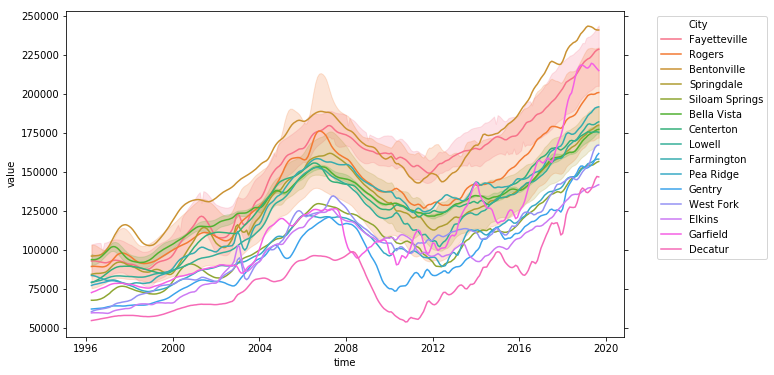

In [37]:
#Plot all the zipcodes from Washington & Benton county
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARCountyMelted)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

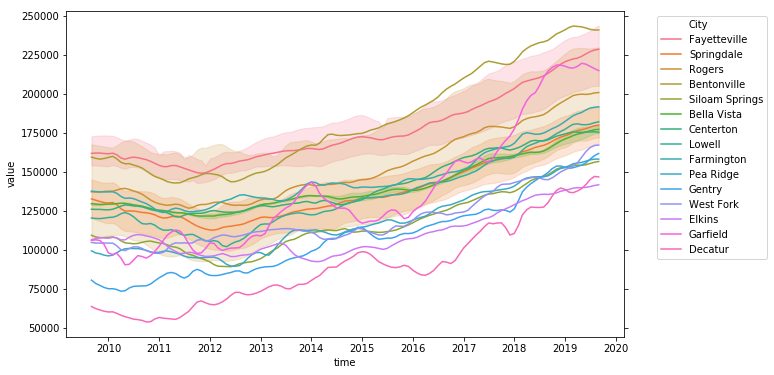

In [38]:
#Plot all the zipcodes with data after 2009
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARCountyMelted2009)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

In [40]:
#Sort dataframe be increase in value and plot
sortedvals = dfARCountyMelted2009.sort_values(by=['Increase'], ascending=False)

In [41]:
increase12 = sortedvals.loc[sortedvals['Increase'] > 12]

In [42]:
groupedvals = increase12.groupby(['RegionName'])

Plot the Cities with increase over 12%. These are the cities we will analyze in the study since they present the biggest ROI.

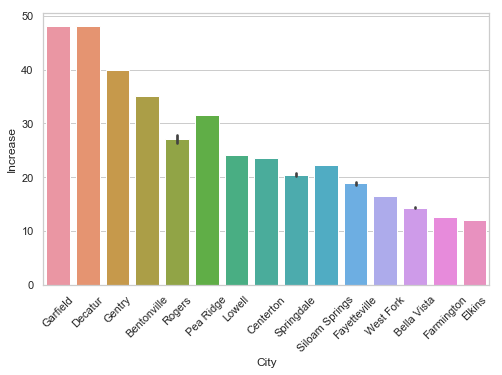

In [43]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
plt.xticks(rotation=45)
ax = sns.barplot(x="City", y="Increase", data=increase12)

In [44]:
#Create dataset by county
WashingtonCounty = dfARCountyMelted2009.loc[dfARCountyMelted2009['CountyName'] == 'Washington County']
BentonCounty = dfARCountyMelted2009.loc[dfARCountyMelted2009['CountyName'] == 'Benton County']

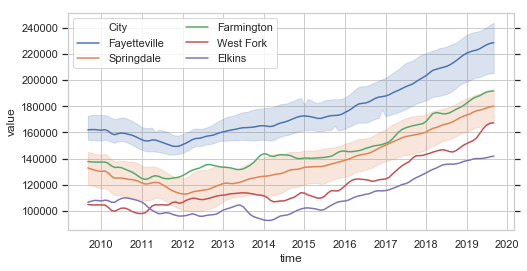

In [45]:
#Washington county plot
plt.figure(figsize=(8, 4))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=WashingtonCounty)
ax.yaxis.set_ticks_position('both')
plt.legend(loc='upper left', ncol=2);

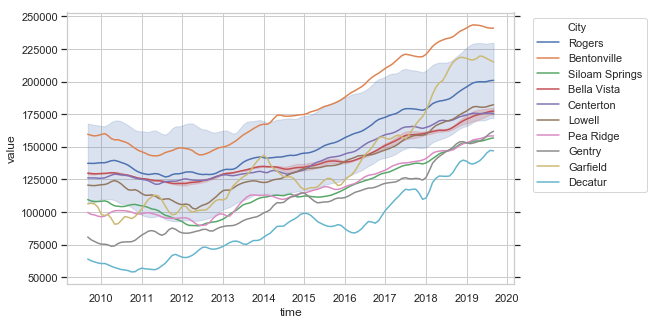

In [46]:
#Benton county plot
plt.figure(figsize=(8, 5))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=BentonCounty)
ax.yaxis.set_ticks_position('both')
plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1.03, 1));

# Zip Codes Time Series

>- Data goes from 2009-09-01 to 2019-09-01
- Cities with an overall increase of 12% were selected

In [47]:
CityList = ['Decatur', 'Gentry', 'Garfield', 'Bentonville', 'Rogers', 'Pea Ridge', 'Lowell', 'Centerton']

In [48]:
dfARStudy = dfARCountyMelted2009.loc[dfARCountyMelted2009['City'].isin(CityList)] 

In [49]:
#Size rank is to compare how big of a city is (urbanization level)
#Size rank #1 is the biggest city, therefore, the higher the number, the less urbanized the zipcode is
sizerankgrouped = dfARStudy.groupby(['SizeRank']).mean()
sizerankgrouped.head(10)

,RegionID,RegionName,AvgPrice_2013,AvgPrice_2018,Increase,value
SizeRank,,,,,,
1483,89745,72758,166100.0,200950.0,20.981337,183846.280992
1542,89743,72756,104500.0,139200.0,33.205742,122957.024793
1844,89712,72712,152100.0,205650.0,35.207101,182296.694215
7525,89718,72719,126450.0,156200.0,23.527086,142008.264463
7806,89737,72745,117050.0,145200.0,24.049551,134971.074380
9606,89740,72751,98550.0,129600.0,31.506849,117451.239669
9632,89727,72734,85350.0,119500.0,40.011716,107500.826446
11080,89725,72732,104300.0,154550.0,48.178332,137316.528926
13257,89720,72722,66500.0,98500.0,48.120301,89305.785124


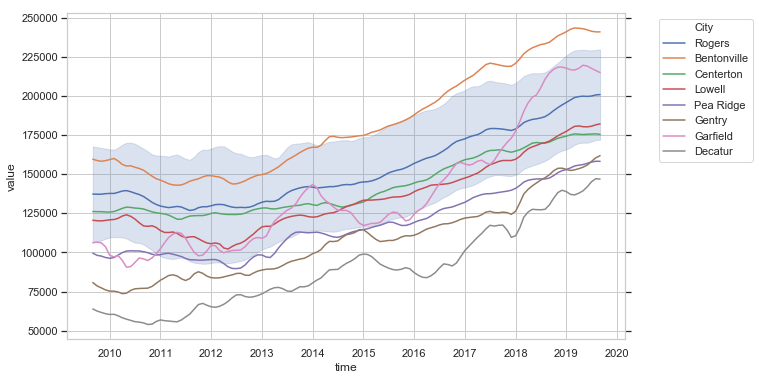

In [50]:
#Plot all the zipcodes under study to visually see their trend
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x="time", y="value", hue="City",
                   data=dfARStudy)
ax.yaxis.set_ticks_position('both')

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1));

##### DF per city

In [51]:
#Create a dataframe per city
Decatur = dfARStudy.loc[dfARStudy['City'] == 'Decatur'] 
Gentry = dfARStudy.loc[dfARStudy['City'] == 'Gentry']
Garfield = dfARStudy.loc[dfARStudy['City'] == 'Garfield'] 
Bentonville = dfARStudy.loc[dfARStudy['City'] == 'Bentonville'] 
Rogers = dfARStudy.loc[dfARStudy['City'] == 'Rogers']
PeaRidge = dfARStudy.loc[dfARStudy['City'] == 'Pea Ridge'] 
Lowell = dfARStudy.loc[dfARStudy['City'] == 'Lowell'] 
Centerton = dfARStudy.loc[dfARStudy['City'] == 'Centerton'] 

#Rogers has 2 zipcodes and we need a single value per time period
Rogers = Rogers.groupby(['time','City', 'State', 'Metro', 'CountyName']).mean().reset_index()

##### Train/Test Split

In [101]:
# The dataset for each state is split into a training and a test set
Decatur_train, Decatur_test = train_test_split(Decatur)
Gentry_train, Gentry_test = train_test_split(Gentry)
Garfield_train, Garfield_test = train_test_split(Garfield)
Bentonville_train, Bentonville_test = train_test_split(Bentonville)
Rogers_train, Rogers_test = train_test_split(Rogers)
PeaRidge_train, PeaRidge_test = train_test_split(PeaRidge)
Lowell_train, Lowell_test = train_test_split(Lowell)
Centerton_train, Centerton_test = train_test_split(Centerton)

Prepare dataset for time series modeling

In [102]:
Train_list = [Decatur_train, Gentry_train, Garfield_train, Bentonville_train, Rogers_train, PeaRidge_train, Lowell_train, Centerton_train]
Test_list = [Decatur_test, Gentry_test, Garfield_test, Bentonville_test, Rogers_test, PeaRidge_test, Lowell_test, Centerton_test]

In [103]:
#Drop unnecessary columns in preparation for time series
#Train set
for i, df in enumerate(Train_list):
    df.drop(columns=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgPrice_2013', 'AvgPrice_2018', 'Increase'], inplace=True)
    df.set_index('time', inplace=True)

#Test set
for i, df in enumerate(Test_list):
    df.drop(columns=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'AvgPrice_2013', 'AvgPrice_2018', 'Increase'], inplace=True)
    df.set_index('time', inplace=True)    

# Stationarity Test

> Check the Stationarity using Dickie Fuller test. This will let us see what data transformations are necessary in order to meet the stationarity assumption for ARIMA. Note that in case the only transformation needed is differencing, ARIMA will take care of it.

> In Dickie Fuller test **H0** = series is not stationary

In [55]:
Train_list = [Decatur_train, Gentry_train, Garfield_train, Bentonville_train, Rogers_train, PeaRidge_train, Lowell_train, Centerton_train]

**Original Series**

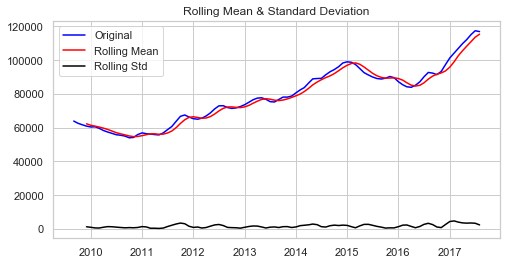

Test Statistic           -0.070669
p-value                   0.952283
#Lags Used               11.000000
Number of observation    84.000000
Critical Value(1%)       -3.510712
Critical Value(5%)       -2.896616
Critical Value(10%)      -2.585482
dtype: float64
/n


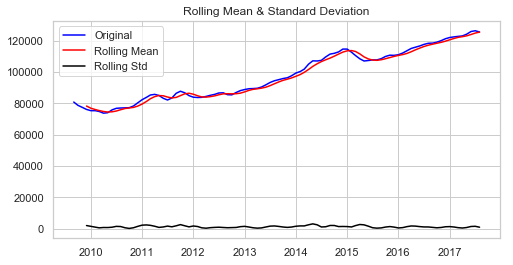

Test Statistic            0.346611
p-value                   0.979385
#Lags Used               11.000000
Number of observation    84.000000
Critical Value(1%)       -3.510712
Critical Value(5%)       -2.896616
Critical Value(10%)      -2.585482
dtype: float64
/n


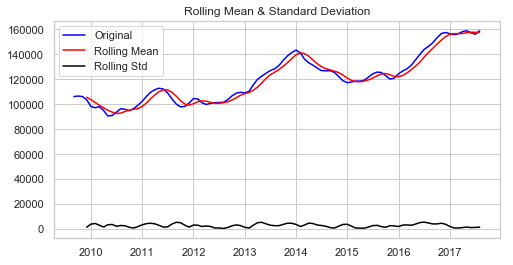

Test Statistic           -0.597719
p-value                   0.871497
#Lags Used                4.000000
Number of observation    91.000000
Critical Value(1%)       -3.504343
Critical Value(5%)       -2.893866
Critical Value(10%)      -2.584015
dtype: float64
/n


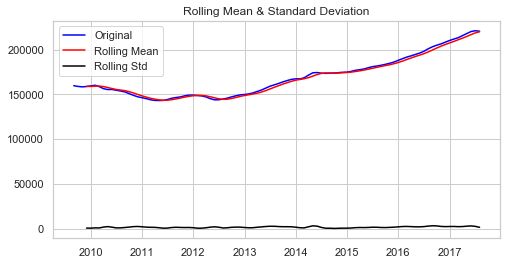

Test Statistic            0.367822
p-value                   0.980251
#Lags Used                4.000000
Number of observation    91.000000
Critical Value(1%)       -3.504343
Critical Value(5%)       -2.893866
Critical Value(10%)      -2.584015
dtype: float64
/n


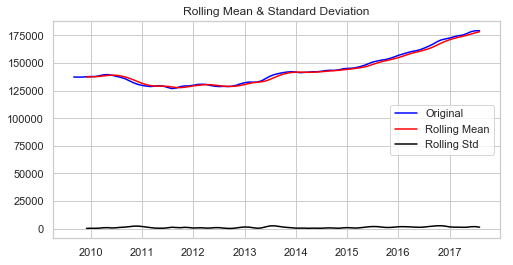

Test Statistic            0.561224
p-value                   0.986620
#Lags Used                3.000000
Number of observation    92.000000
Critical Value(1%)       -3.503515
Critical Value(5%)       -2.893508
Critical Value(10%)      -2.583824
dtype: float64
/n


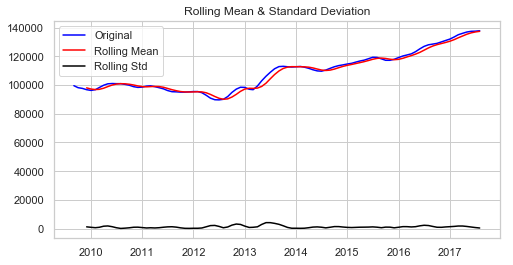

Test Statistic            0.604149
p-value                   0.987717
#Lags Used                5.000000
Number of observation    90.000000
Critical Value(1%)       -3.505190
Critical Value(5%)       -2.894232
Critical Value(10%)      -2.584210
dtype: float64
/n


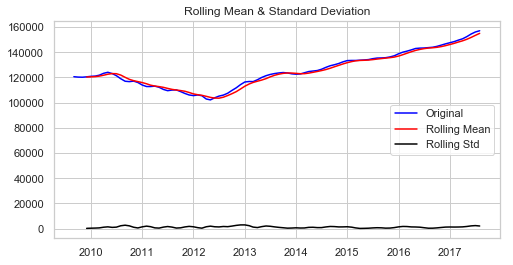

Test Statistic            0.375577
p-value                   0.980558
#Lags Used                8.000000
Number of observation    87.000000
Critical Value(1%)       -3.507853
Critical Value(5%)       -2.895382
Critical Value(10%)      -2.584824
dtype: float64
/n


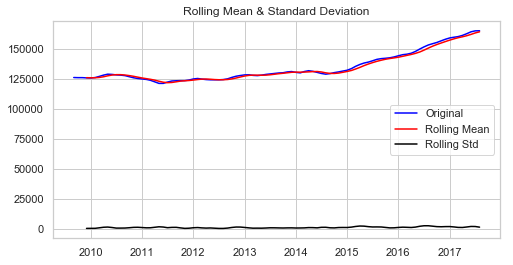

Test Statistic            2.431468
p-value                   0.999024
#Lags Used                7.000000
Number of observation    88.000000
Critical Value(1%)       -3.506944
Critical Value(5%)       -2.894990
Critical Value(10%)      -2.584615
dtype: float64
/n


In [56]:
#Run the Dikie Fuller test for each city under study to assess stationarity
for i, df in enumerate(Train_list):
    output = stationarityTest(df, 4)
    
    print(output)
    print('/n')
 

**Log Transformed**

In [57]:
#Log Transform data
#Run the Dikie Fuller test for each city under study to assess stationarity
for i, df in enumerate(Train_list):
    tslog = np.log(df)
    dftest = adfuller(tslog['value'])
    dfoutput = pd.Series(dftest[1], index =['p-value'])
    print('--City{}: {} '.format(i,dfoutput))

--City0: p-value    0.882507
dtype: float64 
--City1: p-value    0.952017
dtype: float64 
--City2: p-value    0.785938
dtype: float64 
--City3: p-value    0.975607
dtype: float64 
--City4: p-value    0.981309
dtype: float64 
--City5: p-value    0.976748
dtype: float64 
--City6: p-value    0.963897
dtype: float64 
--City7: p-value    0.998957
dtype: float64 


**Differenced**

In [58]:
#Differentiate every city up to 3 times

for i, df in enumerate(Train_list):
    print('////////City {}////////'.format(i))
    for j in [1,2,3]:
        data_diff = df.diff(periods=j)
        data_diff.dropna(inplace=True)
        dftest = adfuller(data_diff['value'])
        dfoutput = pd.Series(dftest[1], index =['p-value'])
        print('Diff {}: {}'.format(j,dfoutput))

////////City 0////////
Diff 1: p-value    0.034622
dtype: float64
Diff 2: p-value    0.003452
dtype: float64
Diff 3: p-value    0.002971
dtype: float64
////////City 1////////
Diff 1: p-value    0.003175
dtype: float64
Diff 2: p-value    0.001941
dtype: float64
Diff 3: p-value    0.019419
dtype: float64
////////City 2////////
Diff 1: p-value    0.011214
dtype: float64
Diff 2: p-value    0.008173
dtype: float64
Diff 3: p-value    0.105652
dtype: float64
////////City 3////////
Diff 1: p-value    0.189667
dtype: float64
Diff 2: p-value    0.340824
dtype: float64
Diff 3: p-value    0.306681
dtype: float64
////////City 4////////
Diff 1: p-value    0.169435
dtype: float64
Diff 2: p-value    0.498266
dtype: float64
Diff 3: p-value    0.154078
dtype: float64
////////City 5////////
Diff 1: p-value    0.021697
dtype: float64
Diff 2: p-value    0.194331
dtype: float64
Diff 3: p-value    0.134337
dtype: float64
////////City 6////////
Diff 1: p-value    0.381578
dtype: float64
Diff 2: p-value    0.4

**Log Transformed & Differenced**

In [59]:
#Differentiate every city up to 3 times
#Log transformed

for i, df in enumerate(Train_list):
    print('////////City {}////////'.format(i))
    for j in [1,2,3]:
        tslog = np.log(df)
        data_diff = tslog.diff(periods=j)
        data_diff.dropna(inplace=True)
        dftest = adfuller(data_diff['value'])
        dfoutput = pd.Series(dftest[1], index =['p-value'])
        print('Diff {}: {}'.format(j,dfoutput))

////////City 0////////
Diff 1: p-value    0.036307
dtype: float64
Diff 2: p-value    0.006585
dtype: float64
Diff 3: p-value    0.00559
dtype: float64
////////City 1////////
Diff 1: p-value    0.003113
dtype: float64
Diff 2: p-value    0.001977
dtype: float64
Diff 3: p-value    0.024358
dtype: float64
////////City 2////////
Diff 1: p-value    0.007585
dtype: float64
Diff 2: p-value    0.005457
dtype: float64
Diff 3: p-value    0.000972
dtype: float64
////////City 3////////
Diff 1: p-value    0.125471
dtype: float64
Diff 2: p-value    0.272376
dtype: float64
Diff 3: p-value    0.25334
dtype: float64
////////City 4////////
Diff 1: p-value    0.130114
dtype: float64
Diff 2: p-value    0.438811
dtype: float64
Diff 3: p-value    0.121735
dtype: float64
////////City 5////////
Diff 1: p-value    0.016255
dtype: float64
Diff 2: p-value    0.145877
dtype: float64
Diff 3: p-value    0.132674
dtype: float64
////////City 6////////
Diff 1: p-value    0.287385
dtype: float64
Diff 2: p-value    0.091

**Rolling Mean Substraction**

In [60]:
for i, ts in enumerate(Train_list):
    rolmean = ts.rolling(window = 2).mean()
    data_minus_rolmean = ts - rolmean
    data_minus_rolmean.dropna(inplace=True)
    
    dftest = adfuller(data_minus_rolmean['value'])
    dfoutput = pd.Series(dftest[1], index =['p-value'])
    print('--City{}: {} '.format(i,dfoutput))

--City0: p-value    0.034622
dtype: float64 
--City1: p-value    0.003175
dtype: float64 
--City2: p-value    0.011214
dtype: float64 
--City3: p-value    0.189667
dtype: float64 
--City4: p-value    0.169435
dtype: float64 
--City5: p-value    0.021697
dtype: float64 
--City6: p-value    0.381578
dtype: float64 
--City7: p-value    0.304151
dtype: float64 


**Diff & Rolling Mean**

In [61]:
#Data Diff & Rolling Mean
for i, ts in enumerate(Train_list):
    print('////////City {}////////'.format(i))
    for j in [1,2,3]:
        
        rolmean = ts.rolling(window = 2).mean()
        data_minus_rolmean = ts - rolmean
        data_minus_rolmean.dropna(inplace=True)
        
        data_diff = data_minus_rolmean.diff(periods=j)
        data_diff.dropna(inplace=True)
        dftest = adfuller(data_diff['value'])
        dfoutput = pd.Series(dftest[1], index =['p-value'])
        print('Diff {}: {}'.format(j,dfoutput))

////////City 0////////
Diff 1: p-value    0.083046
dtype: float64
Diff 2: p-value    0.055079
dtype: float64
Diff 3: p-value    0.054515
dtype: float64
////////City 1////////
Diff 1: p-value    0.008761
dtype: float64
Diff 2: p-value    0.011548
dtype: float64
Diff 3: p-value    0.004035
dtype: float64
////////City 2////////
Diff 1: p-value    2.580171e-07
dtype: float64
Diff 2: p-value    0.001937
dtype: float64
Diff 3: p-value    0.00227
dtype: float64
////////City 3////////
Diff 1: p-value    5.384322e-17
dtype: float64
Diff 2: p-value    0.000337
dtype: float64
Diff 3: p-value    0.002322
dtype: float64
////////City 4////////
Diff 1: p-value    6.513537e-08
dtype: float64
Diff 2: p-value    0.000003
dtype: float64
Diff 3: p-value    0.001837
dtype: float64
////////City 5////////
Diff 1: p-value    1.652136e-09
dtype: float64
Diff 2: p-value    0.000116
dtype: float64
Diff 3: p-value    0.000356
dtype: float64
////////City 6////////
Diff 1: p-value    0.000054
dtype: float64
Diff 2:

> After transforming the data I was able to see that most of my zipcodes require differencing to meet stationarity requirement. A couple of zipcodes will be log transformed in addition to differencing in order to meet stationarity assumption. 

- Difference: Decatur, Gentry, Garfield, PeaRidge
- Difference & Rolling Mean (window = 2): Rogers, Bentonville, Lowell, Centerton 

# Seasonality Check

In [62]:
# Assess seasonality of data 
def check_seasonality(df, col):
    # Use Statsmodels seasonal_decompose function to split time series variation into trend, seasonal variation and white noise
    result = seasonal_decompose(df)
    # Plot Trend, Seasonal and Residual on 3 consecutive axes
    result.trend.plot(ax=axes[0][col])
    axes[0][col].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[1][col])
    axes[1][col].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[2][col])
    axes[2][col].set_ylabel('Residual')

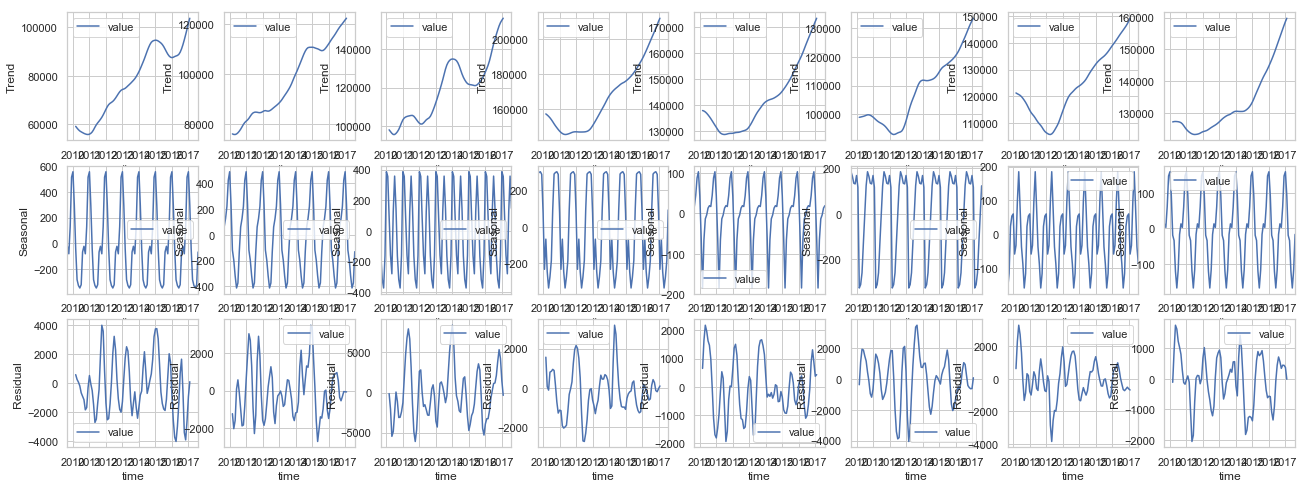

In [63]:
# Create 8X3 grid of plots, each column contains one city, each row contains a trend, seasonal or white noise component
fig, axes = plt.subplots(3,8, figsize=(22,8))
for i, ts in enumerate(Train_list):
    check_seasonality(ts,i)

> Looks like every city time series has seasonality, therefore, we will have to take care of seasonality when creating our model.

# Data Transformation

The approproate data transformation will be applied to the ts based on the Stationarity check done in previous sections.

**Difference**

In [83]:
#This list will be used for modeling
Diff_cities = [Decatur_train, Gentry_train, Garfield_train, PeaRidge_train]

In [65]:
Diff_Decatur_train = Decatur_train.diff(periods=1)
Diff_Gentry_train = Gentry_train.diff(periods=1)
Diff_Garfield_train = Garfield_train.diff(periods=1)
Diff_PeaRidge_train = PeaRidge_train.diff(periods=1)

#This list will be used for ACF and PACF. For the actual modeling we will use Diff_cities list.
PreDiff_cities = [Diff_Decatur_train, Diff_Gentry_train, Diff_Garfield_train, Diff_PeaRidge_train]

#drop NaNs from differenced ts
for i, ts in enumerate(PreDiff_cities):
    ts.dropna(inplace=True)

**Rolling Mean & Diff**

In [66]:
#calculate rolling mean using user defined function
rolmean_Bentonville_train = tsrollingmean(Bentonville_train)
rolmean_Rogers_train = tsrollingmean(Rogers_train)
rolmean_Lowell_train = tsrollingmean(Lowell_train)
rolmean_Centerton_train = tsrollingmean(Centerton_train)

In [67]:
#This list will be used for modeling
Rolmean_cities = [rolmean_Bentonville_train, rolmean_Rogers_train, rolmean_Lowell_train, rolmean_Centerton_train]

In [68]:
#manually differenciate rolling mean transformed ts
diffrollmean_Bentonville_train = rolmean_Bentonville_train.diff(periods=1)
diffrollmean_Bentonville_train.dropna(inplace=True)
diffrollmean_Rogers_train = rolmean_Rogers_train.diff(periods=1)
diffrollmean_Rogers_train.dropna(inplace=True)
diffrollmean_Lowell_train = rolmean_Lowell_train.diff(periods=1)
diffrollmean_Lowell_train.dropna(inplace=True)
diffrollmean_Centerton_train = rolmean_Centerton_train.diff(periods=1)
diffrollmean_Centerton_train.dropna(inplace=True)

In [69]:
diffrolmean_cities = [diffrollmean_Bentonville_train, diffrollmean_Rogers_train, diffrollmean_Lowell_train, diffrollmean_Centerton_train]

# ACF PACF

Before plotting ACF and PACF we need to make sure the time series is stationary. This is the reason why we transformed before plotting.

In [70]:
def check_autocorrelation(df, lags, col):
    plot_acf(df, lags=lags, ax=ax[0][col])
    plot_pacf(df, lags=lags, ax=ax[1][col])

**Diff_cities**

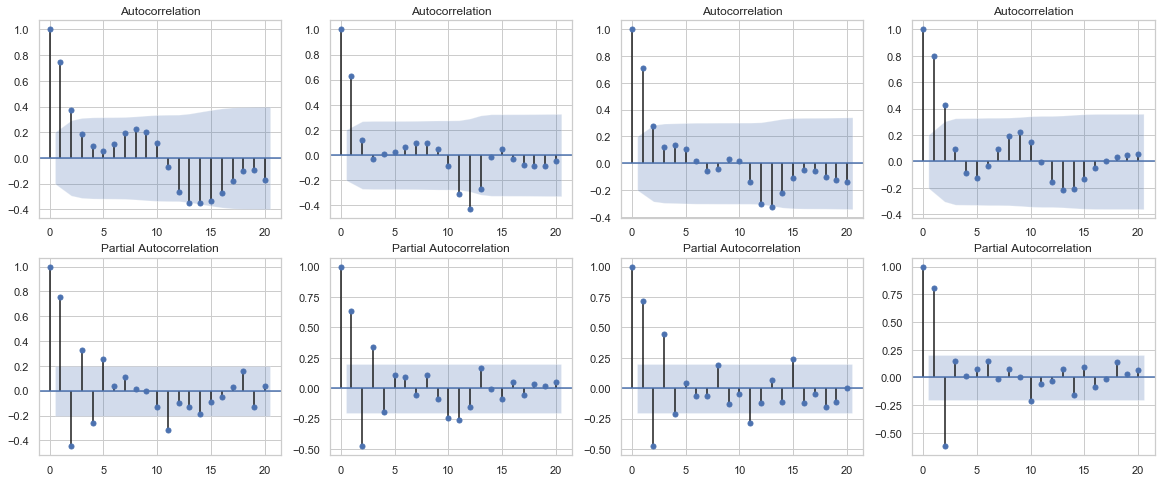

In [71]:
# ACF and PACF of Diff_cities
fig,ax = plt.subplots(2,4,figsize=(20,8))

for i, ts in enumerate(PreDiff_cities):
    check_autocorrelation(ts, 20, i)

**Rolling Mean & Diff cities**

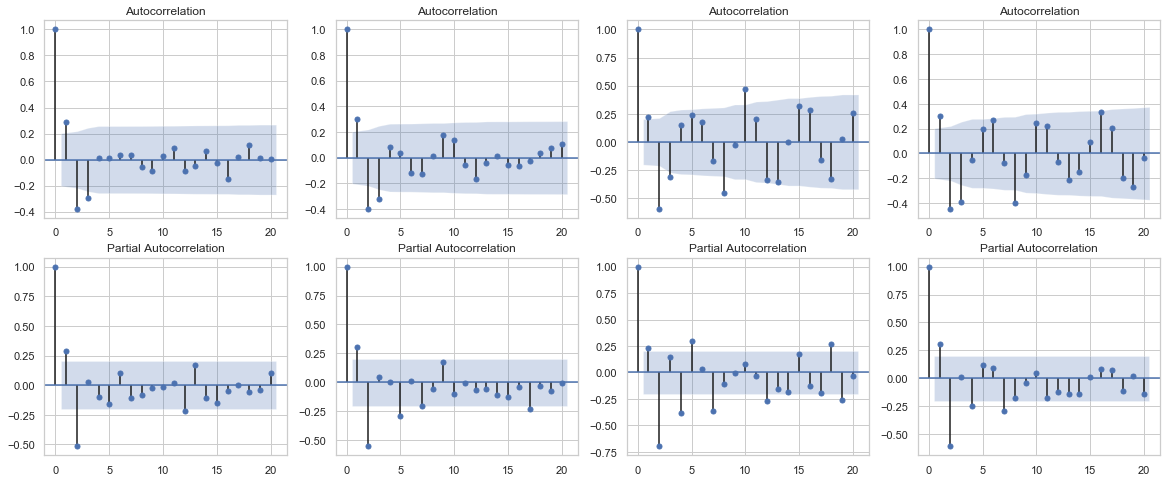

In [72]:
#ACF and PACF of rolling mean & diff cities
fig,ax = plt.subplots(2,4,figsize=(20,8))

for i, ts in enumerate(diffrolmean_cities):
    check_autocorrelation(ts, 20, i)

# ARIMA Modeling

**pm.auto_arima:** Automatically discover the optimal order for an ARIMA model

auto_arima works by conducting different tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller 
or Phillips–Perron) to determine the order of differencing d and the fitting models within ranges of defined startp, maxp, startq, maxq. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

https://www.alkaline-ml.com/pmdarima/modules/classes.html

In [111]:
#This lists will be used for modeling
Diff_cities = [Decatur_train, Gentry_train, Garfield_train, PeaRidge_train]
Rolmean_cities = [rolmean_Bentonville_train, rolmean_Rogers_train, rolmean_Lowell_train, rolmean_Centerton_train]

In [121]:
Diff_cities_test = [Decatur_test, Gentry_test, Garfield_test, PeaRidge_test]

City:  0
ADF Statistic Residual: -2.355027
p-value: 0.154834


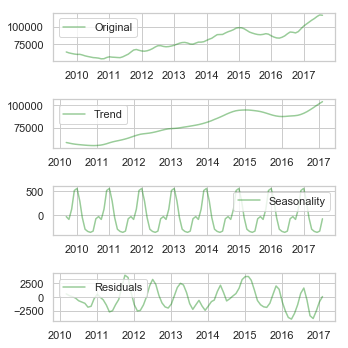

Fit ARIMA: order=(1, 2, 1); AIC=1544.874, BIC=1555.047, Fit time=0.159 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1578.879, BIC=1583.966, Fit time=0.005 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1571.757, BIC=1579.387, Fit time=0.101 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1542.911, BIC=1550.541, Fit time=0.113 seconds
Fit ARIMA: order=(0, 2, 2); AIC=1544.684, BIC=1554.857, Fit time=0.077 seconds
Fit ARIMA: order=(1, 2, 2); AIC=1529.127, BIC=1541.844, Fit time=0.192 seconds
Fit ARIMA: order=(2, 2, 2); AIC=1526.443, BIC=1541.703, Fit time=0.194 seconds
Fit ARIMA: order=(2, 2, 1); AIC=1532.099, BIC=1544.816, Fit time=0.276 seconds
Fit ARIMA: order=(2, 2, 3); AIC=1513.496, BIC=1531.299, Fit time=0.402 seconds
Fit ARIMA: order=(3, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 3); AIC=1511.607, BIC=1526.867, Fit time=0.377 seconds
Fit ARIMA: order=(1, 2, 4); AIC=1512.807, BIC=1530.610, Fit time=0.623 seconds
Fit ARIMA: order=(2, 2, 4); AIC=nan, BIC=nan, Fit time=nan secon

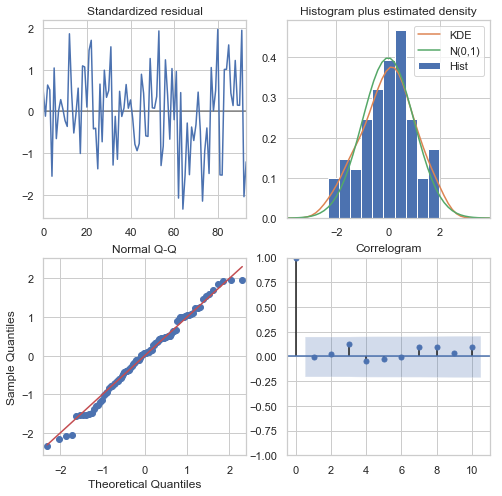

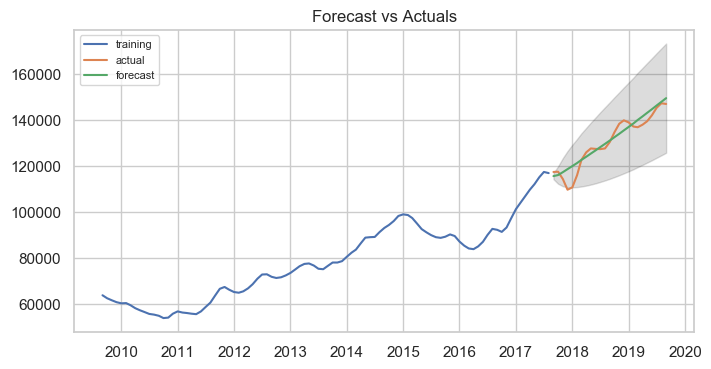

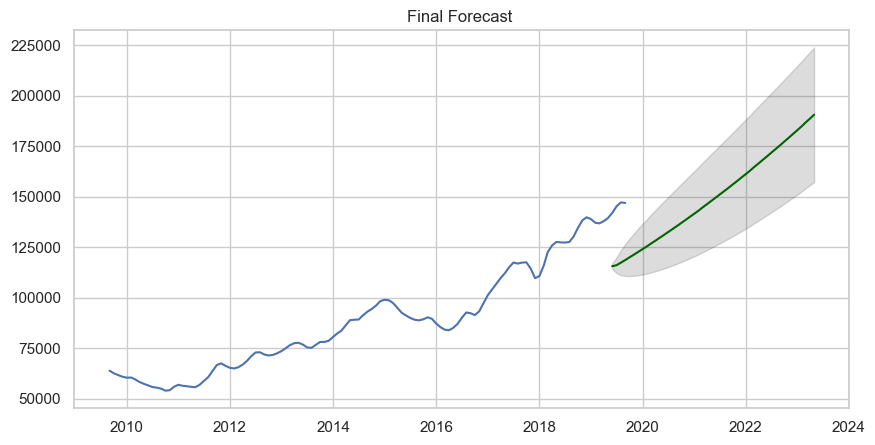

City:  1
ADF Statistic Residual: -2.939785
p-value: 0.040913


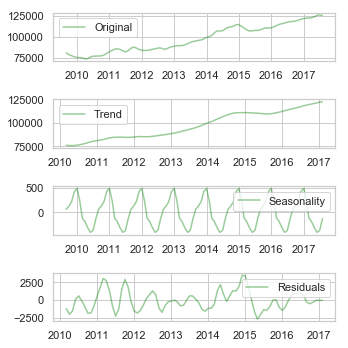

Fit ARIMA: order=(1, 2, 1); AIC=1515.433, BIC=1525.606, Fit time=0.173 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1550.949, BIC=1556.036, Fit time=0.005 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1546.296, BIC=1553.926, Fit time=0.077 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1513.538, BIC=1521.168, Fit time=0.103 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.398 seconds
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   94
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -753.769
Method:                       css-mle   S.D. of innovations            731.673
Date:                Sun, 24 Nov 2019   AIC                           1513.538
Time:                        13:39:00   BIC                           1521.168
Sample:                             2   HQIC  

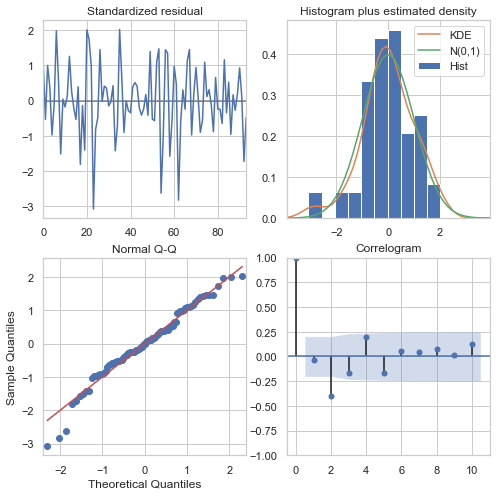

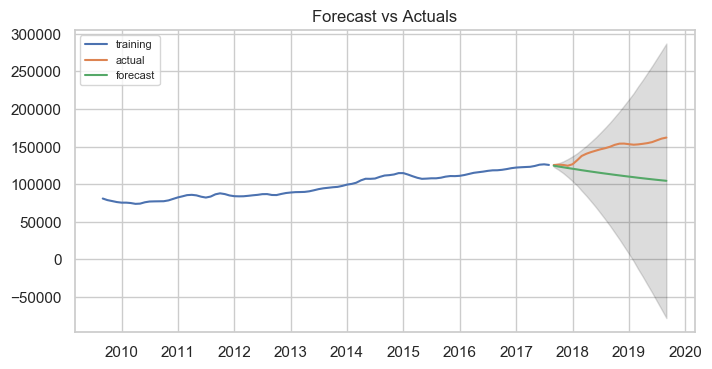

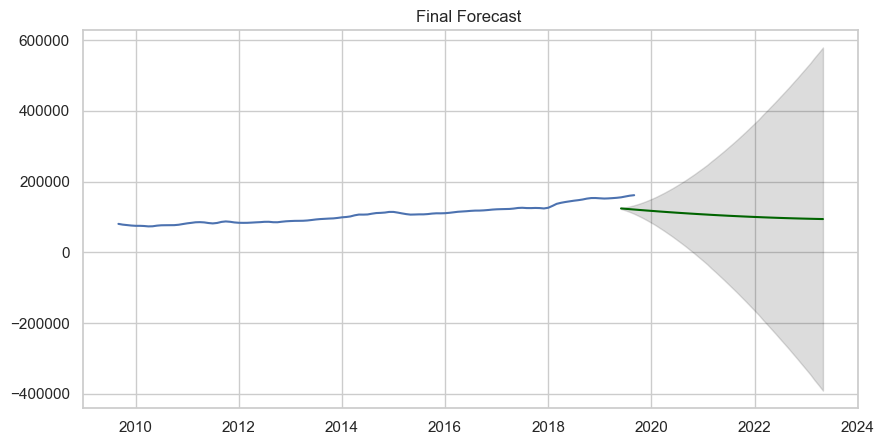

City:  2
ADF Statistic Residual: -3.526704
p-value: 0.007327


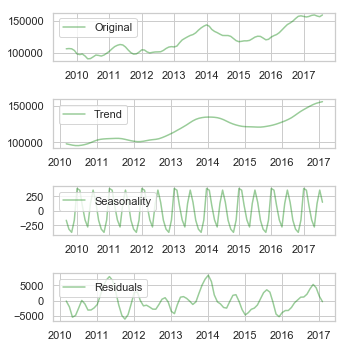

Fit ARIMA: order=(1, 2, 1); AIC=1659.305, BIC=1669.478, Fit time=0.166 seconds
Fit ARIMA: order=(0, 2, 0); AIC=1687.349, BIC=1692.436, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=1681.462, BIC=1689.092, Fit time=0.064 seconds
Fit ARIMA: order=(0, 2, 1); AIC=1657.386, BIC=1665.015, Fit time=0.071 seconds
Fit ARIMA: order=(0, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 2); AIC=1640.313, BIC=1653.030, Fit time=0.209 seconds
Fit ARIMA: order=(2, 2, 2); AIC=1636.325, BIC=1651.584, Fit time=0.540 seconds
Fit ARIMA: order=(2, 2, 1); AIC=1639.321, BIC=1652.038, Fit time=0.249 seconds
Fit ARIMA: order=(2, 2, 3); AIC=1618.675, BIC=1636.478, Fit time=1.092 seconds
Fit ARIMA: order=(3, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 3); AIC=1617.227, BIC=1632.487, Fit time=0.370 seconds
Fit ARIMA: order=(1, 2, 4); AIC=1618.686, BIC=1636.489, Fit time=0.732 seconds
Fit ARIMA: order=(2, 2, 4); AIC=1620.603, BIC=1640.950, Fit time=0.885 secon

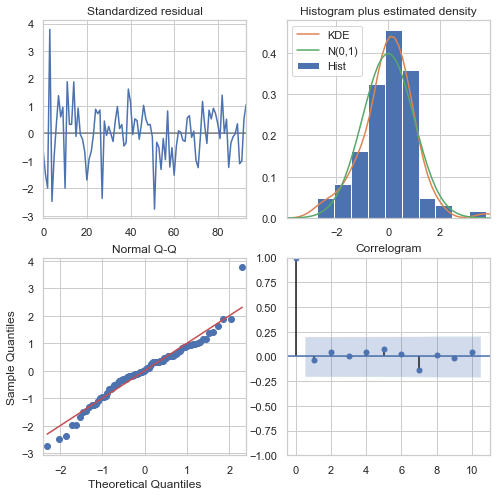

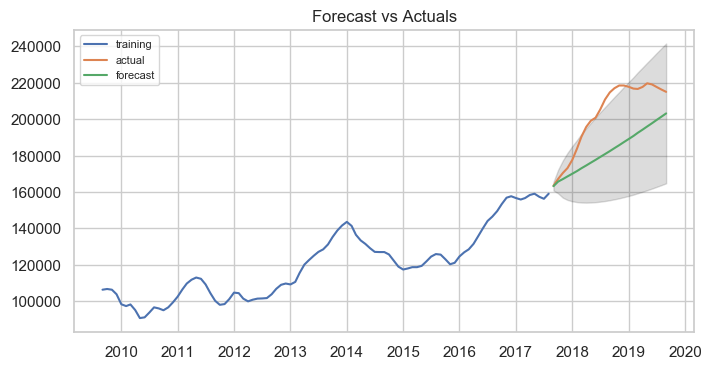

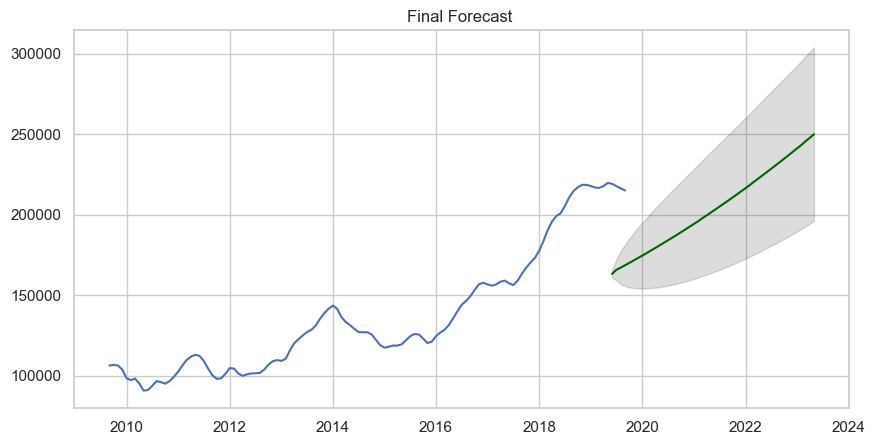

City:  3
ADF Statistic Residual: -3.251412
p-value: 0.017195


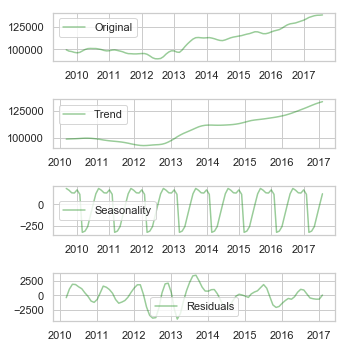

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=1603.317, BIC=1608.424, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1504.614, BIC=1512.276, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1503.819, BIC=1511.481, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 2); AIC=1443.485, BIC=1456.254, Fit time=0.236 seconds
Fit ARIMA: order=(2, 1, 2); AIC=1445.224, BIC=1460.547, Fit time=0.506 seconds
Fit ARIMA: order=(1, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=1448.652, BIC=1466.529, Fit time=0.533 seconds
Total fit time: 1.508 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   95
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -716.743
Method:                       css-mle   S.D. of innovation

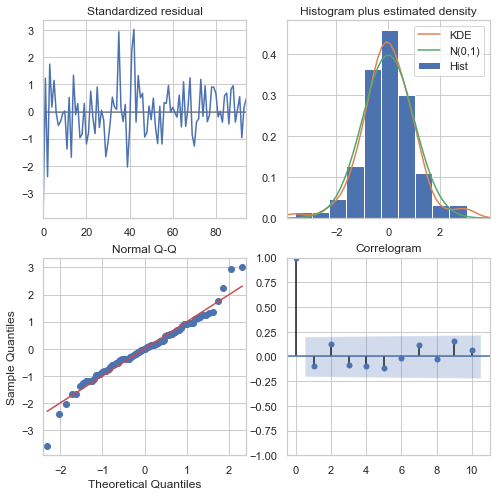

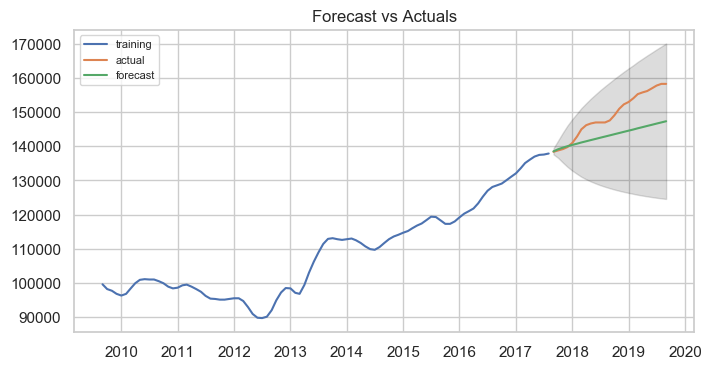

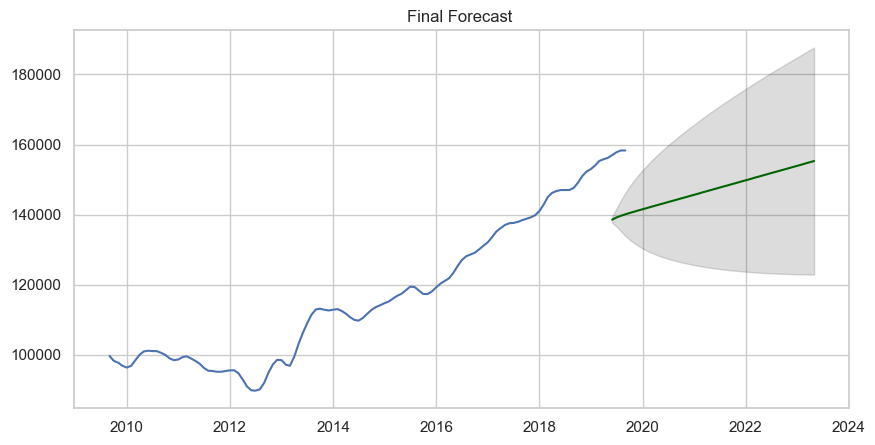

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for i,ts in enumerate(Diff_cities): 
    decomposition = seasonal_decompose(ts)

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    #df_z['res'] = residual ######################Lets see where I need this
    residuals_list.append(residual)
    residual.dropna(inplace=True) #for adfuller ts needs to be free of NaNs and 
#     ts['res'] = residual
    
    # Plot gathered statistics
    plt.figure(figsize=(5,5))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    
#   residual.dropna(inplace=True) #for adfuller ts needs to be free of NaNs and 
    adfuller1D = residual.iloc[:,0].values #you need to make it a 1d series
    result = adfuller(adfuller1D)
    print('City: ', i)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    
    plt.show()
 
    #Will ise pmdarima.auto_arima to get the optimal model order
    model = pm.auto_arima(ts.value.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q -- got this from ACF & PACF
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.show()
    
    #####Plot Train Test - Forecast###
    train = ts
    test = Diff_cities_test[i]
    
    n_test = len(test.value)

    test_index = Diff_cities_test[i].index[:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1) 
    
    # Forecast
    fc, se, conf = fitted.forecast(n_test, alpha=0.05)  # 95% conf
    
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)
    
    # Plot
    plt.figure(figsize=(8,4), dpi=100)
    plt.plot(ts, label='training')
    plt.plot(Diff_cities_test[i], label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    ####Plot Forecast#####
    
    #df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    
    index_of_fc = pd.date_range('2019-05-01', periods=48, freq='M')
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    
    ts_total = ts.append(Diff_cities_test[i])

    plt.plot(fc_series, color='darkgreen')
    plt.plot(ts_total.value)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

#     plt.title("Final Forecast " + str(z) + ' ' + df_z.City[0])
    plt.title("Final Forecast ")
    plt.show()
    

In [ ]:
# Create an empty list to contain the optimal order (p,d,q) and seasonal order (p,d,q,12)
optimal_order_adams = []
optimal_seasonal_order_adams = []

# For each zipcode, select the optimal order and append it to the relevant list
for i in range(0,len(adams_train)):
    
    optimal = optimise_sarimax(adams_train[i], 3,2,2)
    optimal.reset_index(inplace=True)
    
    order = literal_eval(optimal['pdq'][0])
    seasonal_order = literal_eval(optimal['pdqs'][0])
    
    optimal_order_adams.append(order)
    optimal_seasonal_order_adams.append(seasonal_order)

In [ ]:
# Identify optimal order of SARIMAX function.  p, d, and q represent maximum values
def optimise_sarimax(df, p, d, q):
    
    # Create a list with all possible values for p, d and q up to specified maximum
    p = list(range(0,p))
    d = list(range(0,d))
    q = list(range(0,q))


    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency given annual cyclicality)
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    
    # Create dataframe that displays order v. AIC criterion.  Order with lowest AIC selected
    results = []

    for i in range(0, len(pdqs)):
        model = sm.tsa.statespace.SARIMAX(endog=df, order = pdq[i], seasonal_order = pdqs[i], enforce_stationarity = False, enforce_invertibility = False, freq='MS')
        result = model.fit(maxiter=200)
        results.append({'pdq': f"{pdq[i]}", 'pdqs': f"{pdqs[i]}", 'AIC':result.aic})
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by=['AIC'], ascending = True, inplace=True)
    
    return results_df 

# Step 6: Interpreting Results